## Исследование колебаний root во время ходьбы

In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

import plotly.plotly as py
import plotly.graph_objs as go

Read in all data

In [2]:
data_path = '../output/parsed_data/'
flnms = os.listdir(data_path)

df = pd.DataFrame()

for fl in flnms:
    d = pd.read_csv(data_path + fl)
    d = d[d['frame'] > 10]
    df = pd.concat([df, d])

In [3]:
df.shape

(25341, 476)

Интересна ось 0 (по ширине шага)

In [7]:
cols = [
    'ltibia_norm_coord_1',
    'rtibia_norm_coord_1',
    'frame',
    'amc_path',
    'phases_l',
    'phases_r',
    'support'
]

In [8]:
df_data = df[cols]

In [9]:
def dm_to_sm(a):
    b = a / 0.45 * 2.54
    return b

## перевод в см
df_data.loc[:, 'ltibia_norm_coord_1'] = df_data.loc[:, 'ltibia_norm_coord_1'].apply(dm_to_sm)
df_data.loc[:, 'rtibia_norm_coord_1'] = df_data.loc[:, 'rtibia_norm_coord_1'].apply(dm_to_sm)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [42]:
df_data['tibia_min'] = df_data[['ltibia_norm_coord_1', 'rtibia_norm_coord_1']].min(axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [43]:
df_data['tibia_delta'] = 0
df_data.loc[df_data['support'] == 'rss', 'tibia_delta'] = df_data.loc[df_data['support'] == 'rss', 'rtibia_norm_coord_1']
df_data.loc[df_data['support'] == 'lss', 'tibia_delta'] = df_data.loc[df_data['support'] == 'lss','ltibia_norm_coord_1']
df_data.loc[df_data['support'] == 'ds', 'tibia_delta'] = df_data.loc[df_data['support'] == 'ds','tibia_min']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [44]:
ph_amc_agg = df_data.groupby(['amc_path']).agg({'tibia_delta': ['min', 'max']})
ph_amc_agg.columns = ['min_height', 'max_height']
ph_amc_agg.reset_index(inplace=True)

In [48]:
ph_amc_agg.head()

,amc_path,min_height,max_height
0,02_01.amc,-90.256423,-86.701264
1,02_02.amc,-89.796793,-84.403606
2,05_01.amc,-89.458936,-85.432935
3,06_01.amc,-95.125517,-89.854267
4,07_01.amc,-90.064270,-83.096942


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



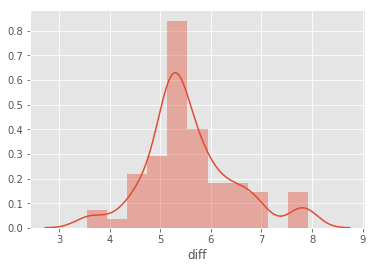

In [49]:
#for all persons
ph_amc_agg['diff'] = ph_amc_agg['max_height'] - ph_amc_agg['min_height']

sns.distplot(ph_amc_agg['diff'])

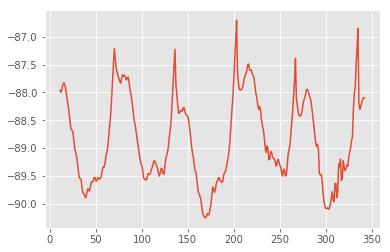

In [47]:
#for one person frint
plt.plot(df.loc[df['amc_path'] == '02_01.amc', 'frame'], df_data.loc[df['amc_path'] == '02_01.amc', 'tibia_delta'])

In [20]:
ph_amc_agg = df_data.groupby(['amc_path', 'support']).agg({'tibia_delta': ['mean', 'std']})
ph_amc_agg.columns = ['mean_tibia_delta', 'sd_tibia_delta']
ph_amc_agg.reset_index(inplace=True)

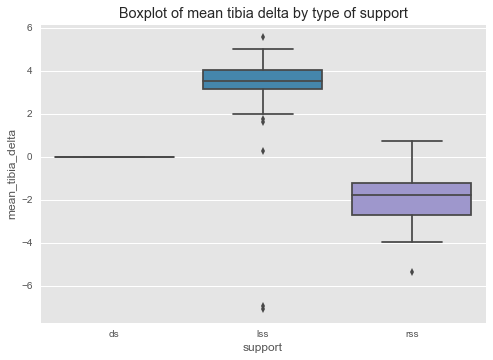

In [22]:
sns.boxplot(data=ph_amc_agg, x='support', y='mean_tibia_delta')
plt.title('Boxplot of mean tibia delta by type of support')

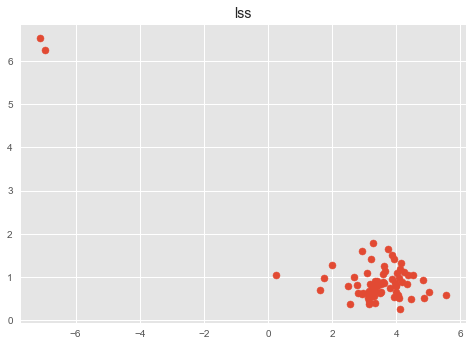

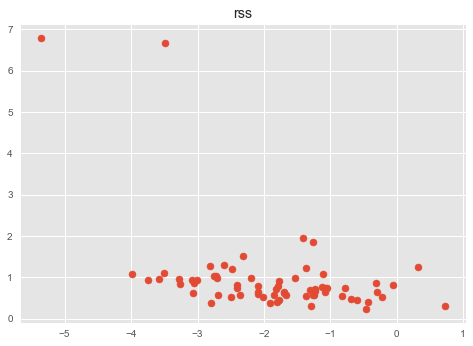

In [23]:
for supp in ['lss', 'rss']:
    d_plt = ph_amc_agg[ph_amc_agg['support'] == supp]
    plt.scatter(d_plt['mean_tibia_delta'], d_plt['sd_tibia_delta'])
    plt.title(supp)
    plt.show()

In [27]:
ph_amc_agg[ph_amc_agg['support'] == 'lss'].sort_values('sd_tibia_delta', ascending=False)[:7]

,amc_path,support,mean_tibia_delta,sd_tibia_delta
91,32_01.amc,lss,-7.099470,6.534535
94,32_02.amc,lss,-6.944040,6.249819
16,07_02.amc,lss,3.283996,1.792890
127,35_14.amc,lss,3.741971,1.646945
163,39_01.amc,lss,2.936645,1.594675
76,16_22.amc,lss,3.855409,1.505752
10,06_01.amc,lss,3.915950,1.420728


In [28]:
ph_amc_agg[ph_amc_agg['support'] == 'rss'].sort_values('sd_tibia_delta', ascending=False)[:7]

,amc_path,support,mean_tibia_delta,sd_tibia_delta
92,32_01.amc,rss,-5.361804,6.791754
95,32_02.amc,rss,-3.493671,6.665246
32,07_09.amc,rss,-1.406046,1.955478
17,07_02.amc,rss,-1.256290,1.847932
194,39_13.amc,rss,-2.315632,1.519358
44,08_02.amc,rss,-2.604627,1.290108
191,39_12.amc,rss,-2.813717,1.272249


In [30]:
bad_amc = ['32_01.amc', '32_02.amc']
ph_amc_agg = ph_amc_agg[~ph_amc_agg['amc_path'].isin(bad_amc)]

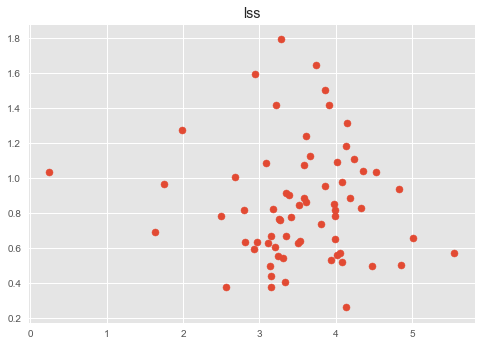

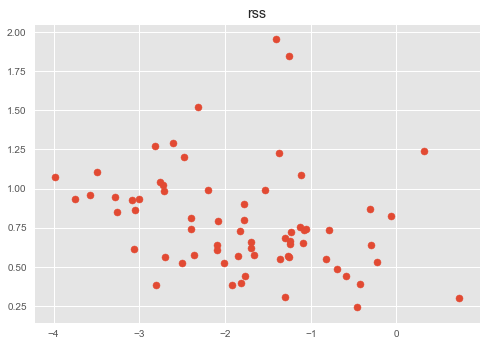

In [31]:
for supp in ['lss', 'rss']:
    d_plt = ph_amc_agg[ph_amc_agg['support'] == supp]
    plt.scatter(d_plt['mean_tibia_delta'], d_plt['sd_tibia_delta'])
    plt.title(supp)
    plt.show()

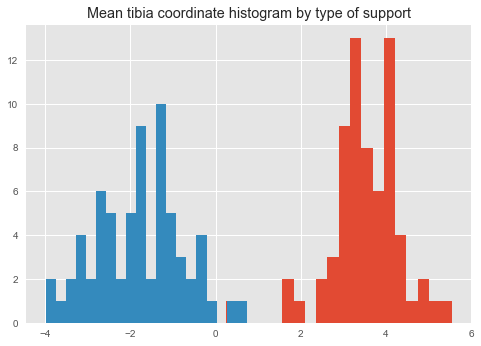

In [39]:
ph_amc_agg[ph_amc_agg['support'] == 'lss']['mean_tibia_delta'].hist(bins=20);
ph_amc_agg[ph_amc_agg['support'] == 'rss']['mean_tibia_delta'].hist(bins=20);
plt.title('Mean tibia coordinate histogram by type of support');

In [36]:
ph_amc_agg[ph_amc_agg['support'] != 'ds'].groupby(['support']).mean_tibia_delta.quantile([0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

support      
lss      0.10    2.747625
         0.25    3.152471
         0.50    3.535950
         0.75    4.019241
         0.80    4.085953
         0.90    4.339497
rss      0.10   -3.069900
         0.25   -2.550976
         0.50   -1.780173
         0.75   -1.178334
         0.80   -1.084029
         0.90   -0.447592
Name: mean_tibia_delta, dtype: float64